In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import networkx as nx
from scipy.stats import norm

### Global parameters

In [2]:
# Number of market participants 
N = 1600 

# Number of fundamentalists and chartists
N_FUND = 1200
N_CHART = 400

# Initial price of the asset traded
P_0 = 100

# Global fundamental price 
P_F = 120

# Variation around the global fundamental price 
THETA = 30

# Maximum extension for chartists' timesteps window 
T_MAX = 15

# Sensitivity of forecasts for fundamentalists
PHI = 2

# Sensitivity of forecasts for chartists 
KAPPA = 2

# level of information dissipation among the agents
ALPHA = 0.95

# Weight of the market imbalance
DELTA = 0.05

# Intervals of variation for the stochastic noise term 
SIGMA = 30

# Sensitivity threshold for choosing the status
TAO = 20

# Asset quantity for each trader
Q = 50

# Information Threshhold
Ith = 1

# Initializing traders' wealth (W), money (M), and asset quantity(Q)
M = 35000  
Q = 50 
W = [M + Q * P_0 for _ in range(N)] 

In [3]:
# Function to calculate expected price for one fundamentalist
def ep_fundamentalist(p_t, P_F):
    """
    Calculate the expected price for a fundamentalist trader

    Parameters:
    p_t (float): The current market price of the asset
    p_f (float): The perceived fundamental price of the asset for the trader

    Returns:
    float: The expected price for the asset for a fundamentalist trader
    """
    noise = np.random.uniform(-SIGMA, SIGMA)
    # Was not too sure about using an uniform or normal distribution here
    p_f = np.random.uniform(P_F - THETA, P_F + THETA)
    ep = p_t + PHI * (p_f - p_t) + noise
    if ep < 0:
        return 0
    return ep

# Function to calculate expected price for one chartist
def ep_chartist(p_t, past_prices):
    """
    Calculate the expected price for a chartist trader

    Parameters:
    p_t (float): The current market price of the asset
    past_prices (list of float): A list of past market prices of the asset

    Returns:
    float: The expected price for the asset as calculated by a chartist trader
    """
    assert len(past_prices) == T_MAX, "past_prices must be a list of 15 values"
    chartist_T = np.random.randint(2, T_MAX)
    p_T = np.mean(past_prices[-chartist_T:]) 
    noise = np.random.uniform(-SIGMA, SIGMA)
    ep = p_t + KAPPA/(chartist_T) * (p_t - p_T) + noise
    if ep < 0:
        return 0
    return ep

# Function that determines the choice one random trader makes
def rand_trader():
    choice = np.random.randint(0, 3)
    return choice
    

### 

In [4]:
# Function to calculate the order type for a non-random trader
def determine_order_type(expected_price, p_t, TAO, money, asset_quantity):
    """
    Determine the order type of a trader based on the expected price, current price,
    sensitivity threshold, available money, and asset quantity

    Parameters:
    expected_price (float): The expected price of the asset
    p_t (float): The current market price of the asset
    TAO (int): The threshold to decide whether to hold
    money (float): The amount of money the trader has
    asset_quantity (int): The quantity of the asset the trader holds

    Returns:
    str: The order type ('buy', 'sell', or 'hold')
    """

    if expected_price > p_t + TAO:
        if money > 0:
            return "buy"  # Buy the asset (bidder)
    elif expected_price < p_t - TAO:
        if asset_quantity > 0:
            return "sell"  # Sell the asset (asker)
    else:
        return "hold"  # Hold without setting any orders

def set_order_price(order_type, expected_price, current_price, money):
    """
    Set the order price for a trader based on their order type, expected price,
    current price, and the amount of money they have

    Parameters:
    order_type (str): The type of order ('buy', 'sell', or 'hold')
    expected_price (float): The expected price of the asset
    current_price (float): The current market price of the asset
    money (float): The amount of money the trader has
    
    Returns:
    float: The price set for the order
    """
    if order_type == 'buy':
        order_price = np.random.uniform(0, min(money, expected_price))
        if order_price < 0:
            return 0
        else:
            return order_price
    elif order_type == 'sell':
        order_price = np.random.uniform(expected_price, current_price)
        if order_price < 0:
            return 0
        else:
            return order_price
    else:
        return 0

In [5]:
# Example usage
current_market_price = P_0
trader_money = M
trader_asset_quantity = Q

ep = ep_fundamentalist(current_market_price, P_F) 
order_type = determine_order_type(ep, P_0, TAO, trader_money, trader_asset_quantity)
order_price = set_order_price(order_type, ep, current_market_price, trader_money)

print(ep)
print(order_type)
print(order_price)

163.2761120056411
buy
71.95151363248539


In [6]:
class OrderBook:
    def __init__(self, delta, agents_dict):
        """
        Initialize the OrderBook with the given delta value.

        Parameters:
        - delta (float): Parameter for price adjustment.
        """
        self.bids = []  # List to store bid orders
        self.asks = []  # List to store ask orders
        self.delta = delta  # Parameter for price adjustment
        self.N_a = 0
        self.N_b = 0
        self.N_T = 0
        self.agents_dict = agents_dict
    
        
    def place_bid(self, trader_id, price):
        """
        Place a bid order in the order book.

        Parameters:
        - trader_id (int): ID of the trader placing the bid.
        - price (float): Bid price.
        """
        self.bids.append({'trader_id': trader_id, 'price': price})
        self.N_b += 1  # Increment the number of bidders
        
    def place_ask(self, trader_id, price):
        """
        Place an ask order in the order book.

        Parameters:
        - trader_id (int): ID of the trader placing the ask.
        - price (float): Ask price.
        """
        self.asks.append({'trader_id': trader_id, 'price': price})
        self.N_a += 1  # Increment the number of askers
        


    def match_orders(self):
        """
        Match bid and ask orders in the order book.

        Returns:
        - list: List of dictionaries representing matched transactions.
        """
        
        N_T = 0 
        
        while self.bids and self.asks:
            best_bid = self.bids[0]
            best_ask = self.asks[0]
            
            if best_bid['price'] >= best_ask['price']:
                # Remove matched orders
                p_L = self.asks[0]['price']
                self.agents_dict[self.asks[0]['trader_id']][3] -= 1 ## assets
                self.agents_dict[self.bids[0]['trader_id']][3] += 1 
                self.agents_dict[self.asks[0]['trader_id']][2] += p_L  
                self.agents_dict[self.bids[0]['trader_id']][2] -= p_L
                self.bids.pop(0)
                self.asks.pop(0)
                self.N_b -= 1
                self.N_a -= 1
                N_T += 1    
            else:
                break  # No more possible transactions
        if self.N_b > self.N_a:
            return N_T, p_L
        else:
            p_L = self.asks[0]['price']
            return N_T, p_L
        

    def set_aggregate_price(self, prev_price):
        """
        Set the aggregate asset price at time t + 1 based on different cases.

        Parameters:
        - prev_price (float): Previous global asset price at time t.
        - N_a (int): Number of askers in the order book.
        - N_b (int): Number of bidders in the order book.

        Returns:
        - float: New global asset price at time t + 1.
        """
        
        self.bids.sort(key=lambda x: x['price'], reverse=True)
        self.asks.sort(key=lambda x: x['price'])
        

        if self.N_a == 0 and self.N_b > 0:
            new_price = prev_price + self.delta * self.N_b
            print('1')
        elif self.N_a > 0 and self.N_b == 0:
            new_price = prev_price - self.delta * self.N_a
            print('2')
        elif 0 < self.N_a < self.N_b and self.bids[0]['price'] < self.asks[0]['price']:
            new_price = prev_price + self.delta * self.N_b
            print('3')
        elif 0 < self.N_a < self.N_b and self.bids[0]['price'] > self.asks[0]['price']:
            N_T,p_L = self.match_orders()
            print('N_b', self.N_b)
            new_price = p_L + self.delta * (self.N_b - N_T)
            print('4')
        elif 0 < self.N_b < self.N_a and self.bids[0]['price'] <= self.asks[0]['price']:
            new_price = prev_price - self.delta * self.N_a
            print('5')
        elif 0 < self.N_b < self.N_a and self.bids[0]['price'] > self.asks[0]['price']:
            print('TOTAL ASKS', self.N_a)
            print('TOTAL BIDS', self.N_b)
            N_T, p_L = self.match_orders()
            print('p_L', p_L)
            print('N_a', self.N_a)
            print('N_a - N_T ', self.N_a - N_T)
            print('p_L-delta*(N_a - N_T)', p_L - self.delta * (self.N_a - N_T))
#             if self.N_a > 50:
#                 self.N_a = 50
            new_price = p_L - self.delta * (self.N_a - N_T)
            print('6')
        else:
            new_price = prev_price
        self.N_a = 0
        self.N_b = 0
        self.bids = []
        self.asks = []
        return new_price


## NETWORK PART

In [7]:
def create_lattice_small_world_network():
    n = 40 # Size of the lattice (n x n)
    k = 4   # Each node is connected to its k nearest neighbors
    p = 0.02 # Probability of rewiring each edge

    # Create a 2D square lattice
    lattice = nx.grid_2d_graph(n, n)

    # Rewire edges with probability p while preserving node degrees
    for edge in list(lattice.edges()):
        if random.random() < p:
            u, v = edge
            possible_edges = [(u, w) for w in lattice if w != v and not lattice.has_edge(v, w)]
            if possible_edges:
                new_v = random.choice(possible_edges)[1]
                lattice.remove_edge(u, v)
                lattice.add_edge(u, new_v)
    return lattice

In [8]:
class Network:
    
    def __init__(self, alpha, agents_dict, network):
        """
        Initialize the OrderBook with the given delta value.

        Parameters:
        - delta (float): Parameter for price adjustment.
        """
    
        self.agents_dict = agents_dict # Dictionary containing each agents and information
        self.network = network 
        self.state_counts = {'buy': [], 'sell': [], 'hold': []}
        self.info_counts = []
        self.alpha = alpha
        self.Ith = Ith
        self.trade_counts = [] # Keep track of amount of trades per simulation
        
    def propagate_info(self, agent_index):
        """
        Propagate information of an agent to its neighbors in the network.

        Parameters:
        - agent_index (int): The index of the agent in the agents dictionary.
        """
        agent = self.agents_dict[agent_index]
        agent_coord = (agent_index // 40, agent_index % 40)  # Map index to coordinates
        neighbors_coords = list(self.network.neighbors(agent_coord))
        if agent[6] >= self.Ith:  # Check if agent's information exceeds the threshold
            self.info_counts[-1] += 1
            store_info = agent[6]
            self.agents_dict[agent_index][6] = 0  # Reset agent's information
            for neighbor_coord in neighbors_coords:
                neighbor_index = neighbor_coord[0] * 40 + neighbor_coord[1]  # Map coordinates to index
                self.agents_dict[neighbor_index][5] = agent[5]   # Propagate decision to neighbor
                self.agents_dict[neighbor_index][4] = agent[4]
                self.agents_dict[neighbor_index][7] = agent[7]
                self.agents_dict[neighbor_index][6] += (self.alpha / len(neighbors_coords)) * store_info
                self.agents_dict[neighbor_index][6] = min(self.agents_dict[neighbor_index][6], np.finfo(float).max)
                if self.agents_dict[neighbor_index][6] >= self.Ith:
                    print('AVALANCHE')
                    self.propagate_info(neighbor_index)  # Recursive call

    def network_cycle(self):
        """
        Update the network for one simulation cycle and collect information for future plots.
        """
        self.info_counts.append(0)  # Reset agent information threshold crossing counter
        copy_agents = self.agents_dict.copy()
        # Add global information
        for agent_id in self.agents_dict:
            self.agents_dict[agent_id][6] += np.random.uniform(0, (self.Ith - max([copy_agents[agent_id][6] for agent_id in copy_agents])))
        # Contagion mechanism
        for i, _ in enumerate(self.agents_dict):
            self.propagate_info(i)

### Simulation

In [9]:
# Initialize agent attributes at T = 0

# structure of agent data
# agents = np.zeros(N, dtype=[('type', 'U10'),# 0
#                             ('wealth', 'f8'),# 1
#                             ('money', 'f8'), # 2
#                             ('assets', 'f8'), # 3
#                             ('expected_price', 'f8'), # 4
#                             ('decision', 'U10'), # 5
#                             ('info', 'f8')]) # 6
#                             ('order price') # 7

agents_dict = {}
past_price = [P_0 for i in range(T_MAX)]
for i in range(800):
    ep = ep_fundamentalist(P_0, P_F)
    #print(ep) 
    agents_dict[i] = ['fund',
                 W[i],
                 M,
                 Q,
                 ep,
                 determine_order_type(ep, P_0, TAO, M, Q),
                 np.random.uniform(0, Ith),
                 0
                 ]

# # Start from where N_FUND stops for integers
for i in range(800, 1600):
    ep = ep_chartist(P_0, past_price)
    agents_dict[i] = ['chart',
                 W[i],
                 M,
                 Q,
                 ep,
                 determine_order_type(ep, P_0, TAO, trader_money, trader_asset_quantity),
                 np.random.uniform(0, Ith),
                 0
                 ]

for agent_id in agents_dict:
    decision = agents_dict[agent_id][5]
    order_price = set_order_price(decision, agents_dict[agent_id][4], P_0, agents_dict[agent_id][2])
    agents_dict[agent_id][7] = order_price

In [10]:
network = create_lattice_small_world_network()
ob = OrderBook(DELTA, agents_dict)
nw = Network(ALPHA, ob.agents_dict, network)

In [11]:
# for cycle in range(10000):
#     print(cycle)
#     nw.network_cycle()

In [15]:
import pickle

# with open('nw_object.pkl', 'wb') as file:
#     pickle.dump(nw, file)
    
with open('nw_object.pkl', 'rb') as input_file:
    nw = pickle.load(input_file)

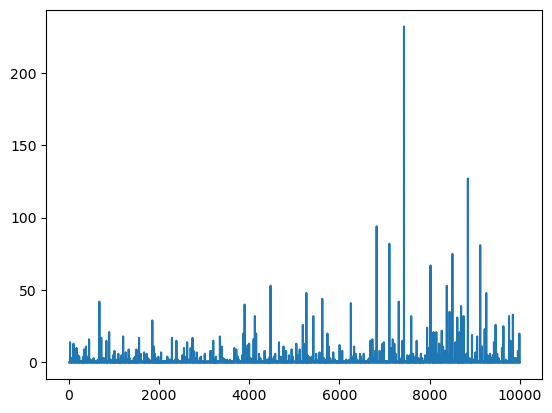

In [16]:
plt.plot(range(10000), nw.info_counts[:10000])

In [17]:
# Simulation 1 cycle
#ob = OrderBook(DELTA, agents_dict)
current_market_price = P_0
simulations = 1000
asset_prices = []
# Check #5, decision in dict to get decision
for sim in range(simulations):
    ob.agents_dict = nw.agents_dict # Send Network agents_dict to Orderbook
    for agent_id in ob.agents_dict:
        decision = ob.agents_dict[agent_id][5]
        order_price = ob.agents_dict[agent_id][7]
        if decision == "buy":
            ob.place_bid(agent_id, order_price)
        elif decision == "sell":
            ob.place_ask(agent_id, order_price)
    current_market_price = ob.set_aggregate_price(current_market_price)
    print('CURRENT MP', current_market_price)
    asset_prices.append(current_market_price)
    past_price.pop(0)
    past_price.append(current_market_price)
    
    for agent_id in range(800): 
        ep = ep_fundamentalist(current_market_price, P_F) 
        ob.agents_dict[agent_id][4] = ep
        ob.agents_dict[agent_id][5] = determine_order_type(ep,
                                                    current_market_price, 
                                                    TAO, ob.agents_dict[agent_id][2],
                                                    ob.agents_dict[agent_id][3])
    for agent_id in range(800, 1600):
        ep = ep_chartist(current_market_price, past_price) 
        ob.agents_dict[agent_id][4] = ep
        ob.agents_dict[agent_id][5] = determine_order_type(ep,
                                                    current_market_price, 
                                                    TAO, ob.agents_dict[agent_id][2],
                                                    ob.agents_dict[agent_id][3])
    
   
    nw = Network(ALPHA, ob.agents_dict, network)
    nw.network_cycle()

N_b 802
4
CURRENT MP 138.3767674289321
TOTAL ASKS 539
TOTAL BIDS 313
p_L 33.05488349155109
N_a 297
N_a - N_T  55
p_L-delta*(N_a - N_T) 30.304883491551088
6
CURRENT MP 30.304883491551088
N_b 439
4
CURRENT MP 133.7608108824605
TOTAL ASKS 483
TOTAL BIDS 352
p_L 9.785340425706746
N_a 274
N_a - N_T  65
p_L-delta*(N_a - N_T) 6.535340425706746
6
CURRENT MP 6.535340425706746
1
CURRENT MP 46.53534042570675
N_b 633
4
CURRENT MP 150.6108108824605
TOTAL ASKS 683
TOTAL BIDS 417
p_L 33.05488349155109
N_a 395
N_a - N_T  107
p_L-delta*(N_a - N_T) 27.704883491551087
6
CURRENT MP 27.704883491551087
N_b 469
4
CURRENT MP 136.6608108824605
TOTAL ASKS 524
TOTAL BIDS 419
p_L 33.05488349155109
N_a 304
N_a - N_T  84
p_L-delta*(N_a - N_T) 28.85488349155109
6
CURRENT MP 28.85488349155109
N_b 483
4
CURRENT MP 137.9108108824605
TOTAL ASKS 505
TOTAL BIDS 408
p_L 33.05488349155109
N_a 289
N_a - N_T  73
p_L-delta*(N_a - N_T) 29.40488349155109
6
CURRENT MP 29.40488349155109
N_b 463
4
CURRENT MP 135.9108108824605
TOTAL

TOTAL ASKS 648
TOTAL BIDS 370
p_L 33.05488349155109
N_a 372
N_a - N_T  96
p_L-delta*(N_a - N_T) 28.254883491551087
6
CURRENT MP 28.254883491551087
N_b 460
4
CURRENT MP 135.6108108824605
TOTAL ASKS 504
TOTAL BIDS 388
p_L 33.05488349155109
N_a 288
N_a - N_T  72
p_L-delta*(N_a - N_T) 29.454883491551087
6
CURRENT MP 29.454883491551087
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
N_b 468
4
CURRENT MP 136.3108108824605
TOTAL ASKS 507
TOTAL BIDS 406
p_L 33.05488349155109
N_a 282
N_a - N_T  57
p_L-delta*(N_a - N_T) 30.204883491551087
6
CURRENT MP 30.204883491551087
N_b 492
4
CURRENT MP 138.7608108824605
TOTAL ASKS 508
TOTAL BIDS 440
p_L 33.05488349155109
N_a 291
N_a - N_T  74
p_L-delta*(N_a - N_T) 29.35488349155109
6
CURRENT MP 29.35488349155109
N_b 477
4
CURRENT MP 137.1608108824605
TOTAL ASKS 494
TOTAL BIDS 436
p_L 40.26438292936191
N_a 283
N_a - N_T  72
p_L-delta*(N_a - N_T) 36.664382929361906
6
CURRENT MP 36.664382929361906
N_b 496
4
CURRENT MP 138.8608108824605
TOTAL ASKS 540
TOTAL BIDS 412
p_

N_b 464
4
CURRENT MP 139.8108108824605
TOTAL ASKS 405
TOTAL BIDS 308
p_L 97.04068892709697
N_a 265
N_a - N_T  125
p_L-delta*(N_a - N_T) 90.79068892709697
6
CURRENT MP 90.79068892709697
N_b 481
4
CURRENT MP 142.7608108824605
TOTAL ASKS 408
TOTAL BIDS 286
p_L 97.04068892709697
N_a 277
N_a - N_T  146
p_L-delta*(N_a - N_T) 89.74068892709697
6
CURRENT MP 89.74068892709697
N_b 477
4
CURRENT MP 141.9608108824605
TOTAL ASKS 415
TOTAL BIDS 291
p_L 113.99639255948782
N_a 283
N_a - N_T  151
p_L-delta*(N_a - N_T) 106.44639255948782
6
CURRENT MP 106.44639255948782
N_b 302
4
CURRENT MP 133.9608108824605
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
TOTAL ASKS 362
TOTAL BIDS 296
p_L 97.04068892709697
N_a 239
N_a - N_T  116
p_L-delta*(N_a - N_T) 91.24068892709697
6
CURRENT MP 91.24068892709697
N_b 474
4
CURRENT MP 142.4108108824605
TOTAL ASKS 371
TOTAL BIDS 276
p_L 113.99639255948782
N_a 258
N_a - N_T  145
p_L-delta*(N_a - N_T) 106.74639255948782
6
CURRENT MP 106.7463

N_b 209
4
CURRENT MP 117.44639255948782
N_b 277
4
CURRENT MP 135.1608108824605
TOTAL ASKS 333
TOTAL BIDS 281
p_L 129.8608108824605
N_a 232
N_a - N_T  131
p_L-delta*(N_a - N_T) 123.3108108824605
6
CURRENT MP 123.3108108824605
N_b 209
4
CURRENT MP 133.2608108824605
TOTAL ASKS 353
TOTAL BIDS 248
p_L 97.04068892709697
N_a 249
N_a - N_T  145
p_L-delta*(N_a - N_T) 89.79068892709697
6
CURRENT MP 89.79068892709697
N_b 473
4
CURRENT MP 142.7108108824605
TOTAL ASKS 358
TOTAL BIDS 271
p_L 117.96119369802577
N_a 265
N_a - N_T  172
p_L-delta*(N_a - N_T) 109.36119369802577
6
CURRENT MP 109.36119369802577
N_b 273
4
CURRENT MP 132.9108108824605
TOTAL ASKS 337
TOTAL BIDS 317
p_L 129.8608108824605
N_a 225
N_a - N_T  113
p_L-delta*(N_a - N_T) 124.21081088246049
6
CURRENT MP 124.21081088246049
N_b 235
4
CURRENT MP 135.4108108824605
TOTAL ASKS 352
TOTAL BIDS 262
p_L 117.96119369802577
N_a 268
N_a - N_T  184
p_L-delta*(N_a - N_T) 108.76119369802576
6
CURRENT MP 108.76119369802576
N_b 299
4
CURRENT MP 134.61

N_b 188
4
CURRENT MP 133.1608108824605
TOTAL ASKS 262
TOTAL BIDS 236
p_L 129.8608108824605
N_a 185
N_a - N_T  108
p_L-delta*(N_a - N_T) 124.46081088246049
6
CURRENT MP 124.46081088246049
N_b 219
4
CURRENT MP 134.4108108824605
N_b 174
4
CURRENT MP 133.5108108824605
TOTAL ASKS 253
TOTAL BIDS 229
p_L 129.8608108824605
N_a 177
N_a - N_T  101
p_L-delta*(N_a - N_T) 124.8108108824605
6
CURRENT MP 124.8108108824605
N_b 202
4
CURRENT MP 134.6108108824605
TOTAL ASKS 271
TOTAL BIDS 261
p_L 129.8608108824605
N_a 192
N_a - N_T  113
p_L-delta*(N_a - N_T) 124.21081088246049
6
CURRENT MP 124.21081088246049
N_b 183
4
CURRENT MP 132.6608108824605
N_b 176
4
CURRENT MP 134.4108108824605
N_b 175
4
CURRENT MP 134.2108108824605
TOTAL ASKS 285
TOTAL BIDS 230
p_L 129.8608108824605
N_a 212
N_a - N_T  139
p_L-delta*(N_a - N_T) 122.9108108824605
6
CURRENT MP 122.9108108824605
N_b 201
4
CURRENT MP 132.8608108824605
N_b 172
4
CURRENT MP 134.2108108824605
TOTAL ASKS 291
TOTAL BIDS 234
p_L 129.8608108824605
N_a 207
N

TOTAL ASKS 293
TOTAL BIDS 243
p_L 129.8608108824605
N_a 205
N_a - N_T  117
p_L-delta*(N_a - N_T) 124.0108108824605
6
CURRENT MP 124.0108108824605
N_b 190
4
CURRENT MP 131.6608108824605
N_b 155
4
CURRENT MP 132.4608108824605
TOTAL ASKS 272
TOTAL BIDS 239
p_L 129.8608108824605
N_a 169
N_a - N_T  66
p_L-delta*(N_a - N_T) 126.5608108824605
6
CURRENT MP 126.5608108824605
N_b 159
4
CURRENT MP 131.5608108824605
N_b 156
4
CURRENT MP 131.7108108824605
TOTAL ASKS 274
TOTAL BIDS 236
p_L 129.8608108824605
N_a 183
N_a - N_T  92
p_L-delta*(N_a - N_T) 125.2608108824605
6
CURRENT MP 125.2608108824605
N_b 178
4
CURRENT MP 132.0108108824605
N_b 172
4
CURRENT MP 133.7108108824605
TOTAL ASKS 286
TOTAL BIDS 260
p_L 129.8608108824605
N_a 180
N_a - N_T  74
p_L-delta*(N_a - N_T) 126.1608108824605
6
CURRENT MP 126.1608108824605
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALA

N_b 145
4
CURRENT MP 129.7108108824605
N_b 138
4
CURRENT MP 129.6108108824605
TOTAL ASKS 277
TOTAL BIDS 269
p_L 129.8608108824605
N_a 154
N_a - N_T  31
p_L-delta*(N_a - N_T) 128.3108108824605
6
CURRENT MP 128.3108108824605
TOTAL ASKS 258
TOTAL BIDS 257
p_L 129.8608108824605
N_a 131
N_a - N_T  4
p_L-delta*(N_a - N_T) 129.6608108824605
6
CURRENT MP 129.6608108824605
N_b 159
4
CURRENT MP 131.2608108824605
TOTAL ASKS 292
TOTAL BIDS 273
p_L 129.8608108824605
N_a 165
N_a - N_T  38
p_L-delta*(N_a - N_T) 127.96081088246049
6
CURRENT MP 127.96081088246049
N_b 149
4
CURRENT MP 130.4108108824605
TOTAL ASKS 269
TOTAL BIDS 258
p_L 129.8608108824605
N_a 147
N_a - N_T  25
p_L-delta*(N_a - N_T) 128.6108108824605
6
CURRENT MP 128.6108108824605
N_b 160
4
CURRENT MP 130.9108108824605
TOTAL ASKS 275
TOTAL BIDS 265
p_L 129.8608108824605
N_a 143
N_a - N_T  11
p_L-delta*(N_a - N_T) 129.3108108824605
6
CURRENT MP 129.3108108824605
TOTAL ASKS 299
TOTAL BIDS 258
p_L 129.8608108824605
N_a 172
N_a - N_T  45
p_L-d

N_b 139
4
CURRENT MP 131.0608108824605
TOTAL ASKS 289
TOTAL BIDS 251
p_L 129.8608108824605
N_a 176
N_a - N_T  63
p_L-delta*(N_a - N_T) 126.71081088246049
6
CURRENT MP 126.71081088246049
N_b 181
4
CURRENT MP 133.3108108824605
TOTAL ASKS 286
TOTAL BIDS 242
p_L 129.8608108824605
N_a 194
N_a - N_T  102
p_L-delta*(N_a - N_T) 124.7608108824605
6
CURRENT MP 124.7608108824605
N_b 176
4
CURRENT MP 131.3608108824605
TOTAL ASKS 287
TOTAL BIDS 247
p_L 129.8608108824605
N_a 192
N_a - N_T  97
p_L-delta*(N_a - N_T) 125.0108108824605
6
CURRENT MP 125.0108108824605
N_b 197
4
CURRENT MP 133.0108108824605
TOTAL ASKS 297
TOTAL BIDS 240
p_L 129.8608108824605
N_a 191
N_a - N_T  85
p_L-delta*(N_a - N_T) 125.6108108824605
6
CURRENT MP 125.6108108824605
N_b 178
4
CURRENT MP 132.4608108824605
TOTAL ASKS 317
TOTAL BIDS 259
p_L 129.8608108824605
N_a 209
N_a - N_T  101
p_L-delta*(N_a - N_T) 124.8108108824605
6
CURRENT MP 124.8108108824605
N_b 173
4
CURRENT MP 132.0608108824605
TOTAL ASKS 280
TOTAL BIDS 272
p_L 129

N_b 221
4
CURRENT MP 134.2608108824605
TOTAL ASKS 299
TOTAL BIDS 252
p_L 129.8608108824605
N_a 195
N_a - N_T  91
p_L-delta*(N_a - N_T) 125.3108108824605
6
CURRENT MP 125.3108108824605
N_b 198
4
CURRENT MP 133.3608108824605
N_b 188
4
CURRENT MP 133.7108108824605
TOTAL ASKS 276
TOTAL BIDS 256
p_L 129.8608108824605
N_a 168
N_a - N_T  60
p_L-delta*(N_a - N_T) 126.8608108824605
6
CURRENT MP 126.8608108824605
N_b 180
4
CURRENT MP 132.7608108824605
TOTAL ASKS 309
TOTAL BIDS 239
p_L 129.8608108824605
N_a 214
N_a - N_T  119
p_L-delta*(N_a - N_T) 123.9108108824605
6
CURRENT MP 123.9108108824605
N_b 187
4
CURRENT MP 132.8608108824605
TOTAL ASKS 274
TOTAL BIDS 258
p_L 129.8608108824605
N_a 171
N_a - N_T  68
p_L-delta*(N_a - N_T) 126.46081088246049
6
CURRENT MP 126.46081088246049
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AV

N_b 181
4
CURRENT MP 132.7608108824605
TOTAL ASKS 311
TOTAL BIDS 246
p_L 129.8608108824605
N_a 204
N_a - N_T  97
p_L-delta*(N_a - N_T) 125.0108108824605
6
CURRENT MP 125.0108108824605
N_b 186
4
CURRENT MP 133.0108108824605
TOTAL ASKS 282
TOTAL BIDS 254
p_L 129.8608108824605
N_a 199
N_a - N_T  116
p_L-delta*(N_a - N_T) 124.0608108824605
6
CURRENT MP 124.0608108824605
N_b 179
4
CURRENT MP 132.1608108824605
TOTAL ASKS 271
TOTAL BIDS 265
p_L 129.8608108824605
N_a 159
N_a - N_T  47
p_L-delta*(N_a - N_T) 127.5108108824605
6
CURRENT MP 127.5108108824605
N_b 137
4
CURRENT MP 131.0608108824605
N_b 176
4
CURRENT MP 132.6108108824605
TOTAL ASKS 294
TOTAL BIDS 249
p_L 129.8608108824605
N_a 195
N_a - N_T  96
p_L-delta*(N_a - N_T) 125.0608108824605
6
CURRENT MP 125.0608108824605
N_b 211
4
CURRENT MP 133.0608108824605
N_b 175
4
CURRENT MP 133.5608108824605
TOTAL ASKS 288
TOTAL BIDS 255
p_L 129.8608108824605
N_a 187
N_a - N_T  86
p_L-delta*(N_a - N_T) 125.5608108824605
6
CURRENT MP 125.5608108824605
N

TOTAL ASKS 265
TOTAL BIDS 251
p_L 129.8608108824605
N_a 158
N_a - N_T  51
p_L-delta*(N_a - N_T) 127.3108108824605
6
CURRENT MP 127.3108108824605
N_b 171
4
CURRENT MP 132.0108108824605
N_b 163
4
CURRENT MP 132.1108108824605
TOTAL ASKS 278
TOTAL BIDS 239
p_L 129.8608108824605
N_a 188
N_a - N_T  98
p_L-delta*(N_a - N_T) 124.96081088246049
6
CURRENT MP 124.96081088246049
N_b 168
4
CURRENT MP 131.5108108824605
TOTAL ASKS 275
TOTAL BIDS 265
p_L 129.8608108824605
N_a 170
N_a - N_T  65
p_L-delta*(N_a - N_T) 126.6108108824605
6
CURRENT MP 126.6108108824605
N_b 176
4
CURRENT MP 132.9608108824605
TOTAL ASKS 257
TOTAL BIDS 248
p_L 129.8608108824605
N_a 162
N_a - N_T  67
p_L-delta*(N_a - N_T) 126.5108108824605
6
CURRENT MP 126.5108108824605
N_b 184
4
CURRENT MP 133.0108108824605
TOTAL ASKS 268
TOTAL BIDS 252
p_L 129.8608108824605
N_a 164
N_a - N_T  60
p_L-delta*(N_a - N_T) 126.8608108824605
6
CURRENT MP 126.8608108824605
N_b 182
4
CURRENT MP 133.1608108824605
TOTAL ASKS 272
TOTAL BIDS 252
p_L 129.8

In [18]:
money = []
zeros = 0
for agent_id in ob.agents_dict:
    money.append(ob.agents_dict[agent_id][2])
    if ob.agents_dict[agent_id][3] == 0:
        print(ob.agents_dict[agent_id][0])
        zeros += 1
print(zeros)

fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund


In [19]:
plt.figure().set_figwidth(15)
plt.plot(list(range(len(asset_prices[400]))), asset_prices[400], label ='asset price')
plt.axhline(y=120, color='r', linestyle='--', label='fundamental price 120')
plt.legend()

TypeError: object of type 'float' has no len()

<Figure size 1500x480 with 0 Axes>

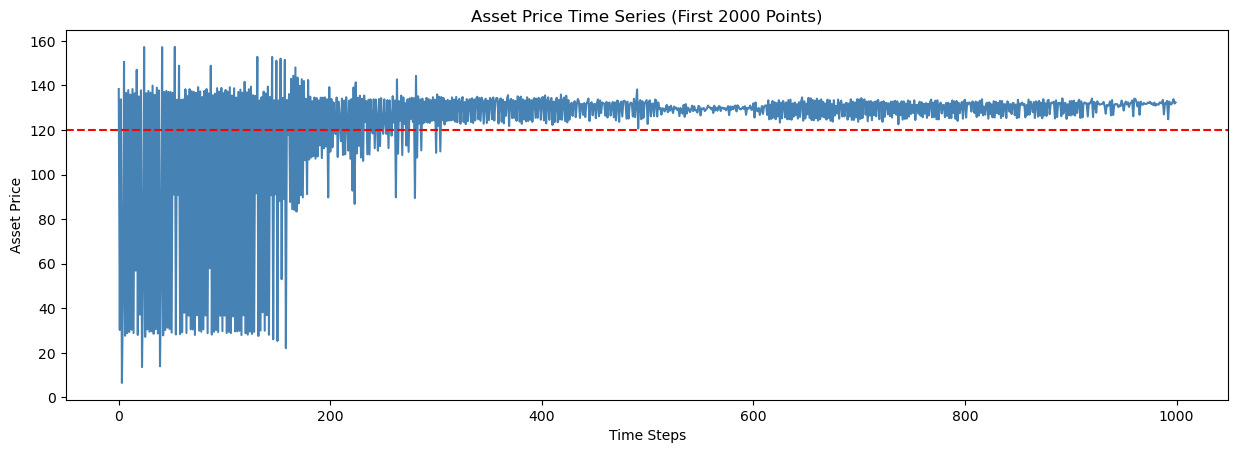

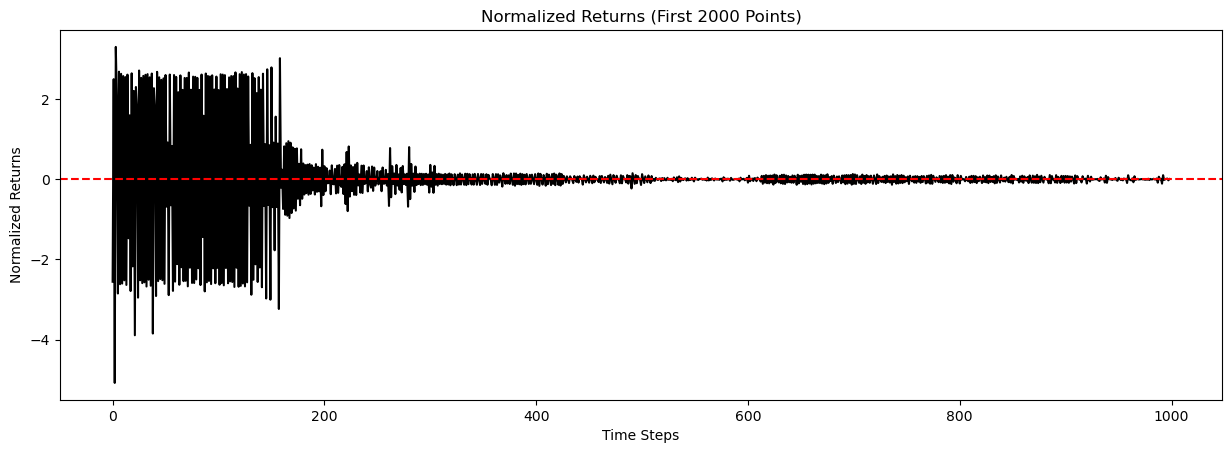

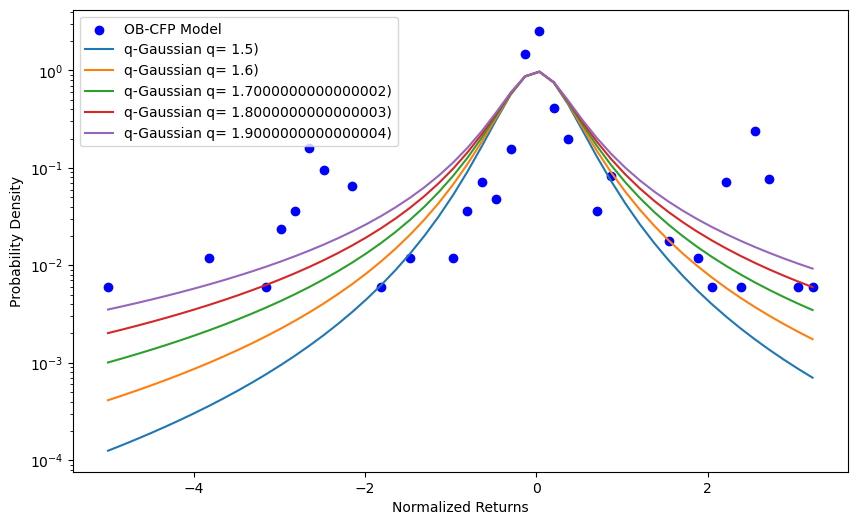

In [21]:
# Use the first 2000 data points
asset_prices_subset = asset_prices

# Calculate returns rt
rt = np.log(asset_prices_subset[1:]) - np.log(asset_prices_subset[:-1])

# Calculate average return and standard deviation
r_avg = np.mean(rt)
r_stdev = np.std(rt)

# Calculate normalized returns r^NORM
r_norm = (rt - r_avg) / r_stdev

# Plot the asset price time series
plt.figure().set_figwidth(15)
plt.plot(asset_prices_subset, color='steelblue')
plt.axhline(y=120, color='r', linestyle='--')
plt.title('Asset Price Time Series (First 2000 Points)')
plt.xlabel('Time Steps')
plt.ylabel('Asset Price')
plt.show()

# Plot the normalized returns time series
plt.figure().set_figwidth(15)
plt.plot(r_norm, color='black')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Normalized Returns (First 2000 Points)')
plt.xlabel('Time Steps')
plt.ylabel('Normalized Returns')
plt.show()

# Calculate the probability density function (PDF) of the normalized returns
counts, bin_edges = np.histogram(r_norm, bins=50, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
# Plot the PDF of the normalized returns
plt.figure(figsize=(10, 6))
plt.scatter(bin_centers, counts, label='OB-CFP Model', color='blue')

# Fit a Gaussian distribution
# params_norm = norm.fit(r_norm)
# pdf_gaussian = norm.pdf(bin_centers, *params_norm)
# plt.plot(bin_centers, pdf_gaussian, label='Gaussian', linestyle='--', color='steelblue')

# Definition of the q-Gaussian function
def q_gaussian(x, A, B, q):
    return A * np.power(1 - (1 - q) * B * x**2, 1 / (1 - q))

# Parameters for the q-Gaussian
A = 0.98
B = 7
q_list = np.arange(1.5, 2.0, 0.1)


# Plot the q-Gaussian
for q in q_list:
    plt.plot(bin_centers, q_gaussian(bin_centers, A, B, q), label=f'q-Gaussian q= {q})')

plt.yscale('log')
plt.xlabel('Normalized Returns')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

In [ ]:
# Definition of the q-Gaussian function
def q_gaussian(x, A, B, q):
    return A * np.power(1 - (1 - q) * B * x**2, 1 / (1 - q))

# Parameters for the q-Gaussian
A = 0.98
B = 7

In [ ]:
import numpy as np
from scipy.optimize import minimize

# Data provided
data = np.array(bin_centers)

# Definition of the q-Gaussian function
def q_gaussian(x, A, B, q):
    return A * np.power(1 - (1 - q) * B * x**2, 1 / (1 - q))

# Negative log likelihood function
def negative_log_likelihood(params):
    A, B, q = params
    likelihood = np.sum(np.log(q_gaussian(data, A, B, q)))
    return -likelihood

# Initial parameter guesses
initial_guess = [0.98, 7, 1.5]

# Minimize the negative log likelihood
result = minimize(negative_log_likelihood, initial_guess, bounds=[(0, None), (0, None), (1, 3)])

# Extract the best fitting parameters
A_fit, B_fit, q_fit = result.x

A_fit, B_fit, q_fit

